In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import torch

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Bert/new_data (2).csv')

In [ ]:
df

,Label,Text
0,alarmed,Great Grandpa’s thoughts on global warming \n\...
1,alarmed,The best companies understand that sustainabil...
2,alarmed,@AnnaJaneSmith4 @MaxGraham @Char_Autographs Th...
3,alarmed,"RT mwasa ""RT EUClimateAction: #Happy_New_Year_..."
4,alarmed,@JacobCastellan9 @ScottAdamsSays @TheDocMalibu...
...,...,...
12079,disengaged,I haven't taken the time to research or learn...
12080,disengaged,Climate change is not an issue that I feel pe...
12081,disengaged,I don't have a strong opinion on climate chan...
12082,disengaged,Climate change seems like a complex and overw...


In [ ]:
# Remove rows with less than 5 words in the 'text' column
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))
df = df[df['word_count'] >= 5]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Drop the 'word_count' column as it's not needed anymore
df = df.drop('word_count', axis=1)





In [ ]:
df

,Label,Text
0,alarmed,Great Grandpa’s thoughts on global warming \n\...
1,alarmed,The best companies understand that sustainabil...
2,alarmed,@AnnaJaneSmith4 @MaxGraham @Char_Autographs Th...
3,alarmed,"RT mwasa ""RT EUClimateAction: #Happy_New_Year_..."
4,alarmed,@JacobCastellan9 @ScottAdamsSays @TheDocMalibu...
...,...,...
11966,disengaged,I haven't taken the time to research or learn...
11967,disengaged,Climate change is not an issue that I feel pe...
11968,disengaged,I don't have a strong opinion on climate chan...
11969,disengaged,Climate change seems like a complex and overw...


In [ ]:

# Load your data

X = df['Text']
y = df['Label']

In [ ]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=876)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }




In [ ]:
# Initialize tokenizer and create DataLoader
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = TextDataset(X_train, y_train, tokenizer, max_length=128)
test_dataset = TextDataset(X_test, y_test, tokenizer, max_length=128)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Load and fine-tune BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(le.classes_))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = torch.tensor(class_weights, dtype=torch.float)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 4)

In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, device, class_weights):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        weighted_loss = torch.mean(torch.stack([class_weights[label.item()] * loss for i, label in enumerate(labels)]))
        weighted_loss.backward()
        total_loss += weighted_loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    return total_loss / len(dataloader)



In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.detach().cpu().numpy())

    return predictions, true_labels

In [ ]:
# Train the model for a few epochs
num_epochs = 10
for epoch in range(num_epochs):
    loss = train_epoch(model, train_dataloader, optimizer, scheduler, device, class_weights)
    print(f"Epoch: {epoch+1}, Loss: {loss:.4f}")

# Evaluate the model
predictions, true_labels = evaluate(model, test_dataloader, device)
print(classification_report(true_labels, predictions, target_names=le.classes_))

Epoch: 1, Loss: 1.0822
Epoch: 2, Loss: 0.8643
Epoch: 3, Loss: 0.7243
Epoch: 4, Loss: 0.6118
Epoch: 5, Loss: 0.5693
Epoch: 6, Loss: 0.5797
Epoch: 7, Loss: 0.5699
Epoch: 8, Loss: 0.5728
Epoch: 9, Loss: 0.5746
Epoch: 10, Loss: 0.5758
              precision    recall  f1-score   support

     alarmed       0.86      0.91      0.88      1490
    cautious       0.29      0.34      0.31       137
   concerned       0.34      0.23      0.27       246
  disengaged       0.61      0.39      0.48       165
  dismissive       0.41      0.57      0.48       243
    doubtful       0.63      0.32      0.43       114

    accuracy                           0.71      2395
   macro avg       0.52      0.46      0.48      2395
weighted avg       0.70      0.71      0.70      2395



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")






Accuracy: 0.7069
Precision: 0.7018
Recall: 0.7069
F1 Score: 0.6976


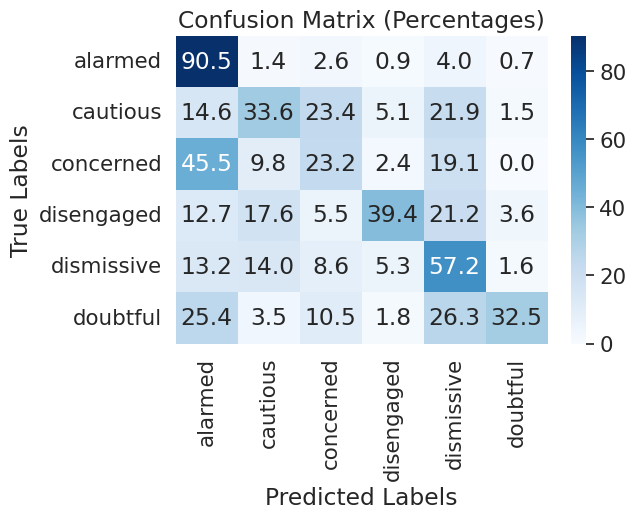

              precision    recall  f1-score   support

     alarmed       0.86      0.91      0.88      1490
    cautious       0.29      0.34      0.31       137
   concerned       0.34      0.23      0.27       246
  disengaged       0.61      0.39      0.48       165
  dismissive       0.41      0.57      0.48       243
    doubtful       0.63      0.32      0.43       114

    accuracy                           0.71      2395
   macro avg       0.52      0.46      0.48      2395
weighted avg       0.70      0.71      0.70      2395



In [ ]:
# Evaluate the model
predictions, true_labels = evaluate(model, test_dataloader, device)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Calculate row sums for normalization
row_sums = conf_matrix.sum(axis=1)

# Create a normalized confusion matrix with percentages
conf_matrix_norm = conf_matrix / row_sums[:, np.newaxis] * 100

# Create a heatmap visualization of the confusion matrix
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_norm, annot=True, cmap="Blues", fmt='.1f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentages)')
plt.show()

# Print classification report
print(classification_report(true_labels, predictions, target_names=le.classes_))


